# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.240203,True,6.368019
1,-0.030287,True,3.732935
2,0.626349,True,3.984674
3,1.903016,True,9.741755
4,2.565331,True,8.733669
...,...,...,...
995,1.361044,True,7.347626
996,-1.038372,False,-1.917245
997,-0.494545,False,-0.696518
998,0.616165,False,-0.046264


<Axes: xlabel='v0'>

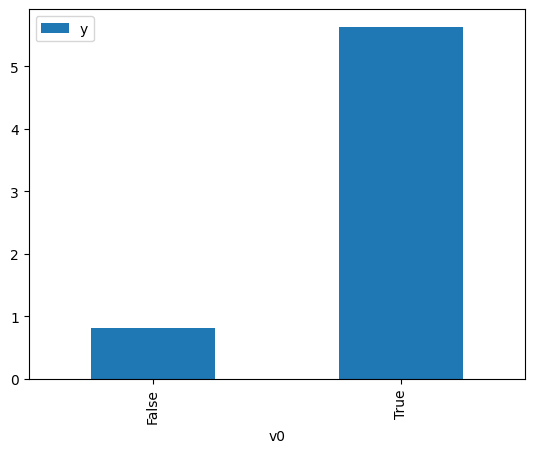

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

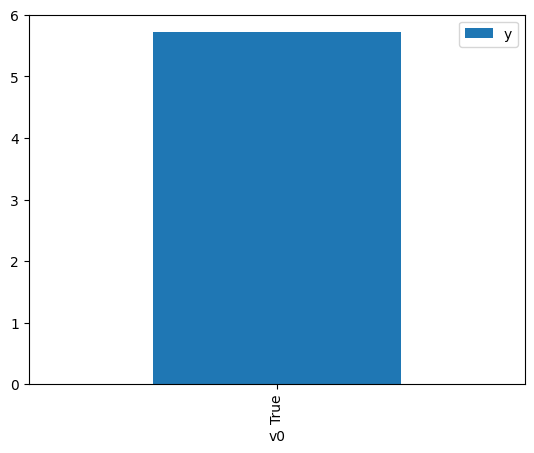

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.175582,False,1.644802,0.477064,2.096156
1,2.379993,False,2.360069,0.055931,17.879047
2,0.416117,False,1.902827,0.403679,2.477216
3,1.147551,False,0.393226,0.214603,4.659770
4,0.906979,False,1.550044,0.269137,3.715577
...,...,...,...,...,...
995,-0.119269,False,0.640080,0.568053,1.760399
996,0.731738,False,2.161791,0.313966,3.185059
997,0.789059,False,3.232301,0.298858,3.346071
998,0.726100,False,2.715173,0.315474,3.169833


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.123284,True,6.461992,0.780280,1.281591
1,0.076603,True,4.017976,0.492261,2.031445
2,0.869329,True,6.046039,0.721579,1.385850
3,1.362919,True,5.921152,0.827003,1.209185
4,0.767859,True,6.165547,0.695603,1.437602
...,...,...,...,...,...
995,0.795606,True,6.167604,0.702841,1.422797
996,2.098908,True,9.149229,0.922544,1.083959
997,0.876318,True,5.154273,0.723317,1.382520
998,1.754300,True,5.532201,0.885946,1.128736


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                          1.152e+04
Date:                Fri, 01 Dec 2023   Prob (F-statistic):                        0.00
Time:                        15:06:34   Log-Likelihood:                         -1421.5
No. Observations:                1000   AIC:                                      2847.
Df Residuals:                     998   BIC:                                      2857.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2988      0.037     35.393      0.000       1.227       1.371
x2             5.0147      0.052     96.660      0.000       4.913       5.117
==============================================================================
Omnibus:                        4.970   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.083   Jarque-Bera (JB):                5.080
Skew:                          -0.123   Prob(JB):                       0.0789
Kurtosis:                       3.247   Cond. No.                         2.20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""